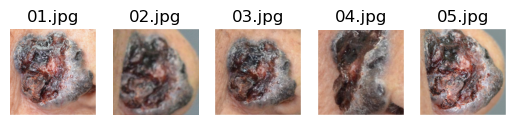

In [26]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

image_paths = sorted(Path('src').glob('*'))
images = [Image.open(p).convert('RGB') for p in image_paths]
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
])

fig, axs = plt.subplots(1, 5, squeeze=True)
for i in range(len(axs)):
    image_path = image_paths[i]
    axs[i].set_title(f"{image_path.name}")
    axs[i].imshow(images[i])
    axs[i].axis('off')
plt.show()

In [50]:
transform(images[0])

tensor([[[0.9059, 0.9098, 0.8902,  ..., 0.9529, 0.9255, 0.9412],
         [0.8980, 0.9098, 0.9020,  ..., 0.9569, 0.9294, 0.9451],
         [0.8863, 0.8980, 0.9098,  ..., 0.9647, 0.9333, 0.9451],
         ...,
         [0.8510, 0.8627, 0.8824,  ..., 0.8000, 0.7725, 0.8549],
         [0.8118, 0.8392, 0.8549,  ..., 0.7804, 0.7529, 0.8431],
         [0.8510, 0.8784, 0.8824,  ..., 0.8588, 0.8431, 0.9059]],

        [[0.6902, 0.6902, 0.6745,  ..., 0.8431, 0.8314, 0.8902],
         [0.6824, 0.6902, 0.6863,  ..., 0.8471, 0.8353, 0.8941],
         [0.6706, 0.6824, 0.7020,  ..., 0.8510, 0.8392, 0.8941],
         ...,
         [0.5922, 0.6235, 0.6627,  ..., 0.6118, 0.6000, 0.7569],
         [0.5725, 0.6157, 0.6471,  ..., 0.6157, 0.6118, 0.7608],
         [0.7451, 0.7804, 0.8000,  ..., 0.7686, 0.7608, 0.8510]],

        [[0.5608, 0.5608, 0.5451,  ..., 0.7490, 0.7529, 0.8275],
         [0.5569, 0.5608, 0.5608,  ..., 0.7529, 0.7569, 0.8314],
         [0.5490, 0.5608, 0.5765,  ..., 0.7569, 0.7569, 0.